In [1]:
# ---------------------------------------------------------
#        Keywords, WordClouds, and Topic Modeling
# ---------------------------------------------------------

import pandas as pd
import numpy as np
from ast import literal_eval
from tqdm import tqdm

# 1. Load the Data (The one with Sentiment Labels we just saved)
df = pd.read_csv('../data/processed/sentiment_data.csv')

# 2. Fix Formatting
# CSVs turn lists like ['a', 'b'] into strings "['a', 'b']". We fix that here.
if 'clean_tokens_list' in df.columns:
    tqdm.pandas(desc="Converting lists")
    df['clean_tokens_list'] = df['clean_tokens_list'].progress_apply(
        lambda x: literal_eval(x) if isinstance(x, str) else x
    )

print("Data Loaded Successfully.")
print(f"Total Rows: {len(df)}")

Converting lists: 100%|██████████| 4548/4548 [00:00<00:00, 24255.63it/s]

Data Loaded Successfully.
Total Rows: 4548


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from hazm import stopwords_list

# --- WARNINGS & MISSING VALUES ---
# 1. Force 'df' to be a standalone copy so Pandas doesn't complain
df = df.copy()

# 2. Fill missing values safely
df['clean_comment_text'] = df['clean_comment_text'].fillna('')
df = df[df['clean_comment_text'].str.strip() != ''] 

# 3. Prepare Corpus
prof_corpus = df.groupby('professor_name')['clean_comment_text'].apply(lambda x: ' '.join(x.astype(str))).reset_index()

# 4. Setup Stopwords (Including your fix)
persian_stopwords = list(stopwords_list())
extra_stops = ['آید', 'توان', 'تواند', 'توانند', 'رسد', 'رود', 'سال', 'نمی', 'های', 'گوید', 'گویند']
persian_stopwords.extend(extra_stops)

# 5. Configure TF-IDF
vectorizer = TfidfVectorizer(
    max_df=0.95,
    min_df=2,
    max_features=1000,
    stop_words=persian_stopwords
)

# 6. Run the Math
tfidf_matrix = vectorizer.fit_transform(prof_corpus['clean_comment_text'])
feature_names = vectorizer.get_feature_names_out()

# 7. Extract Keywords
def get_top_keywords(row_idx, top_n=10):
    row_data = tfidf_matrix[row_idx]
    top_indices = row_data.toarray().flatten().argsort()[::-1][:top_n]
    return ", ".join([feature_names[i] for i in top_indices])

prof_corpus['top_keywords'] = [get_top_keywords(i) for i in range(len(prof_corpus))]

print("Keywords extracted:")
display(prof_corpus.head(5))

Keywords extracted:


,professor_name,clean_comment_text,top_keywords
0,ابراهیم اردشیر لاریجانی,چیزی اضافه ایی نیست چیزی اضافه ایی نیست ایشون ...,"نمره, ترم, رندوم, کد, پروژه, اضافه, ایمیل, میا..."
1,ابراهیم تیموری,استاد خوش اخلاقی هستند، سه امتحان می گیرن ، ام...,"ای, نمره, ست, استاد, عالیه, تی, ازمونک, کمک, د..."
2,ابن الرسول,ایشون خیلی زیاد در مورد حواشی و موارد بی ربط ص...,"مدیریت, موارد, اصلی, فصل, صحبت, ایشون, سر, درس..."
3,ابوالفضل اسکندری,خلاصه بگم... استاد اصلا تدریس نمیکنند و ازمایش...,"ازمایش, گزارش, عملی, بپرسید, غیبت, استاد, ازتو..."
4,ابوالفضل دیانت,از نحوه عملکرد تیم ta راضی نبودم چیزی اضافه ای...,"کلاسی, پروژه, تشریحی, نمره, برگزار, اکثرا, ۱۲,..."


Generating Word Clouds for the first 3 Professors...


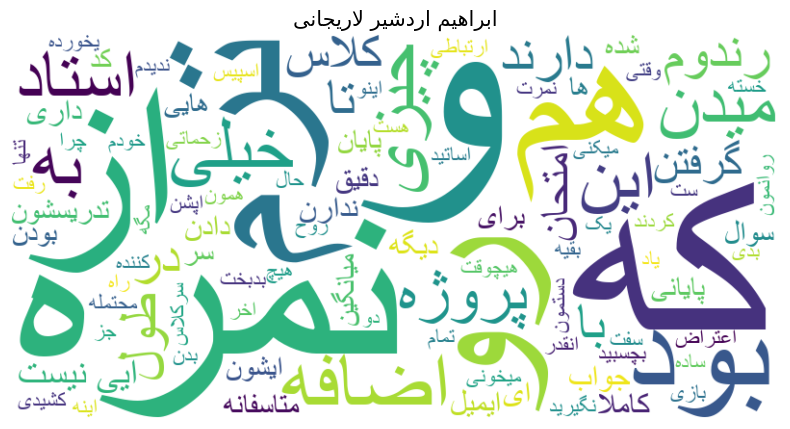

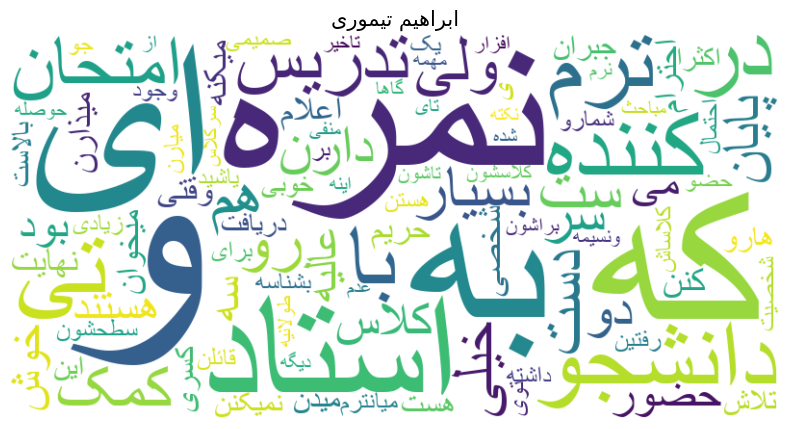

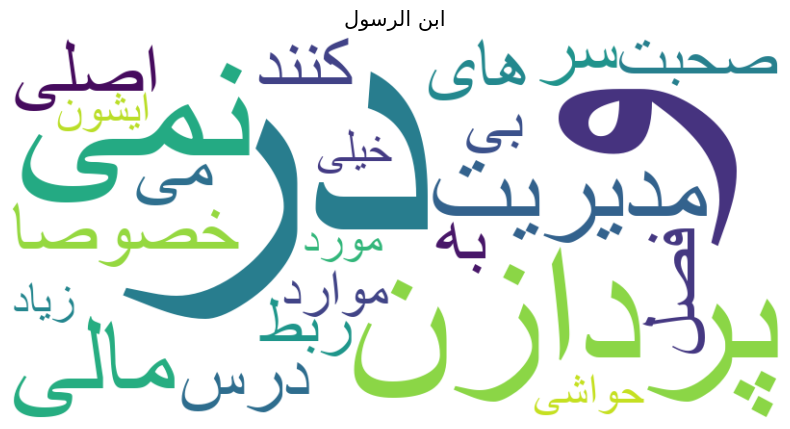

In [7]:
from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib.pyplot as plt
import os

# Configuration
# Windows usually has Arial. If you are on Mac/Linux, we might need a different path.
FONT_PATH = 'C:\\Windows\\Fonts\\arial.ttf' 

if not os.path.exists(FONT_PATH):
    print(f"Warning: Font not found at {FONT_PATH}. Text might appear as squares.")
    FONT_PATH = None 

def plot_persian_wordcloud(text, title):
    # 1. Reshape text (Connect letters correctly)
    reshaped_text = arabic_reshaper.reshape(text)
    
    # 2. Fix direction (Right-to-Left)
    bidi_text = get_display(reshaped_text)
    
    # 3. Generate Cloud
    wc = WordCloud(
        font_path=FONT_PATH,
        background_color='white',
        width=800, 
        height=400,
        max_words=100
    ).generate(bidi_text)
    
    # 4. Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    
    # Reshape title for display
    display_title = get_display(arabic_reshaper.reshape(title))
    plt.title(display_title, fontsize=15)
    plt.show()

# Run for the first 3 Professors as a demo
print("Generating Word Clouds for the first 3 Professors...")

for i in range(3):
    row = prof_corpus.iloc[i]
    prof_name = row['professor_name']
    
    # We use the raw text (all comments combined) to make the cloud rich
    all_text = row['clean_comment_text']
    
    plot_persian_wordcloud(all_text, prof_name)

In [8]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# 1. Convert Text to Numbers (Bag of Words)
# LDA works better with simple counts (CountVectorizer) than TF-IDF

# We use the same stopwords list you perfected earlier
tf_vectorizer = CountVectorizer(
    max_df=0.95, 
    min_df=2, 
    max_features=1000, 
    stop_words=persian_stopwords
)

tf = tf_vectorizer.fit_transform(df['clean_comment_text'])
tf_feature_names = tf_vectorizer.get_feature_names_out()

# 2. Run LDA (The AI Part)
# We ask it to find 3 distinct topics
n_topics = 3
print(f"Running LDA to find {n_topics} hidden topics...")

lda = LatentDirichletAllocation(
    n_components=n_topics, 
    max_iter=10, 
    learning_method='online', 
    random_state=42
)

lda.fit(tf)

# 3. Display the Results
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx + 1}: "
        # Get the top 15 words for this topic
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        message += " - ".join(top_words)
        print(message)
        print("-" * 50)

print("\nThe 3 Main Topics in Student Comments:")
print_top_words(lda, tf_feature_names, 15)

Running LDA to find 3 hidden topics...

The 3 Main Topics in Student Comments:
Topic #1: نمره - درس - کلاس - اصلا - استاد - ترم - ایشون - اگه - سر - یه - میده - میدن - ها - امتحان - نمیشه
--------------------------------------------------
Topic #2: استاد - اضافه - ایی - هستن - دانشجو - ایشون - خوش - درس - میدن - میکنن - واقعا - دارن - کلاسشون - باهاشون - تدریس
--------------------------------------------------
Topic #3: نمره - ترم - کلاس - امتحان - استاد - ای - ها - حضور - سر - تدریس - تی - میدن - یه - جزوه - تمرین
--------------------------------------------------
